In [886]:
# Import common libraries
import pandas as pd
import numpy as np
from copy import deepcopy
import importlib
import mne


# Import MNE processing
from mne_nirs.statistics import statsmodels_to_results, run_glm

# Scikit Learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import matplotlib as mpl
from mne.stats import fdr_correction, permutation_t_test


# Internal Packages
import analysis_tools
import system_file_io
import quality_eval
import dynamic_interval_tools
import glm_analysis
import visualizations
import cross_conditional_comparison

# Reset the cache
importlib.reload(analysis_tools)
importlib.reload(system_file_io)
importlib.reload(dynamic_interval_tools)
importlib.reload(glm_analysis)
importlib.reload(visualizations)

<module 'visualizations' from '/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py'>

In [826]:
# ------------------------------------------------------------------
# Recurring values that we will allow for users to change in the GUI
# ------------------------------------------------------------------

# Length of the measured interval
interval_length = 15

# Time from trigger point being evaluated
tmin = -1
tmax = 15

# Does the study have variable task lengths or does the study follow a block design?
variable_epoch_time = False





In [827]:
# FV Study Parameters
# ignore = [".DS_Store", ".git", "sub-14", "sub-18", ".gitignore"]
ignore = [".DS_Store", ".git", "sub-14", "sub-15", "sub-16", "sub-17", "sub-18", "sub-19", ".gitignore"]
columns_for_group_analysis = ['Neutral', 'Concern']
columns_for_glm_contrast = ['Neutral', 'Concern']
path = '../../FV_Prelim_Data/'
trigger_id = {'1': 'Start', '2': 'Neutral', '3': 'Concern'}
columns_for_fdr = ['Neutral', 'Concern']
sc_present = False

In [828]:
# FA Study Parameters
# columns_for_group_analysis = ['Neutral', 'Inflam', 'Control']
# columns_for_glm_contrast = ['Neutral', 'Inflam', 'Control']
# columns_for_fdr = ['Control', 'Inflam']
# path = "../../LabResearch/IndependentStudy/Data/FA"
# ignore = [".DS_Store", "sub-03", ".git", ".gitignore"]
# trigger_id = {'4': 'Control', '2': 'Neutral', '3': 'Inflam', '1':'Practice'}

In [829]:
# Oculus Montage Parameters
# columns_for_group_analysis = ['oneBack', 'twoBack', 'threeBack']
# columns_for_glm_contrast = ['oneBack', 'twoBack', 'threeBack']
# path = '../../../Desktop/oculus_montage_bids/'
# ignore = [".DS_Store", ".git", ".gitignore"]
# trigger_id = {'1': 'oneBack', '2': 'twoBack', '3': 'threeBack'}

In [830]:
# N-Back Control Montage Parameters
# columns_for_group_analysis = ['oneBack', 'twoBack', 'threeBack']
# columns_for_glm_contrast = ['oneBack', 'twoBack', 'threeBack']
# path = '../../../Desktop/n-back-bids/'
# ignore = [".DS_Store", ".git", ".gitignore"]
# trigger_id = {'1': 'oneBack', '2': 'twoBack', '3': 'threeBack'}

In [831]:
# Live Drive
# ignore = [".DS_Store", ".git", "sub-01", ".gitignore"]
# columns_for_group_analysis = ['Driving']
# columns_for_glm_contrast = ['Driving']
# path = '../../LiveDrive'
# trigger_id = {'2': 'Driving'}
# columns_for_fdr = ['Driving']

In [832]:
# VR Driving
# ignore = [".DS_Store", ".git", ".gitignore"]
# columns_for_group_analysis = ['Driving']
# columns_for_glm_contrast = ['Driving']
# path = '../../Drive_VR/'
# trigger_id = {'2': 'Driving'}
# columns_for_fdr = ['Driving']
# sc_present = True

In [833]:
# Live Drive w/ Pause
# ignore = [".DS_Store", ".git", ".gitignore"]
# columns_for_group_analysis = ['Driving']
# columns_for_glm_contrast = ['Driving']
# path = '../../Driving_with_pause/'
# trigger_id = {'2': 'Driving'}
# columns_for_fdr = ['Driving']
# sc_present = True

In [834]:

def run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, sc_present, tmin=None, tmax=None, trigger_id=None):
    # Establish the groups, subject names, and snirf file paths for all subjects
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}
    for group in groups:
        paths = df[df.eq(group).any(1)]['snirf_path'].to_numpy()

        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=paths, trigger_id=trigger_id, variable_epoch_time = variable_epoch_time, tmin=tmin, tmax=tmax)
        
        print("sc_present group analysis", sc_present)
        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, sc_present, tmin, tmax)
        print("GLM Data Processed ---> Calcuating GLM Dataframe")
        
        # Converts the glm design matrixes into a dataframe
        df_cha, df_con, glm_results = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        raw_haemo = all_data[0]['raw_haemo']
        
        print("GLM Dataframe Generated. Finding all significant channels")
        # Find the groups significant channels
        ch_model_df = analysis_tools.create_results_dataframe(df_cha, columns_for_glm_contrast, raw_haemo)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(ch_model_df)

        glm_dataframes[group] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds, glm_results

In [835]:
def run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, sc_present, tmin=None, tmax=None, trigger_id=None):
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}

    paths = df[df.any(1)]['snirf_path'].to_numpy()

    for id, path in enumerate(paths):
        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=[path], trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, sc_present, tmin, tmax)
        
        raw_haemo = all_data[0]['raw_haemo']

        # Converts the glm design matrixes into a dataframe
        df_cha, df_con, glm_results = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        ch_model_df = analysis_tools.create_results_dataframe(df_cha, columns_for_glm_contrast, raw_haemo)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(ch_model_df)

        glm_dataframes[f'sub-{id+1}'] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds, glm_results

In [836]:
importlib.reload(analysis_tools)
importlib.reload(glm_analysis)
print(sc_present)
group_data, all_epochs, all_evokeds, glm_results = run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, sc_present, tmin=tmin, tmax=tmax, trigger_id=trigger_id)

# print(glm_results)


False
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-13/nirs/2023-03-09_001.snirf
Reading 0 ... 9146  =      0.000 ...   899.052 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-12/nirs/2023-02-10_003.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 8750  =      0.000 ...   860.125 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-08/nirs/2023-02-17_002.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 9088  =      0.000 ...   893.350 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-01/nirs/2023-02-17_002.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Reading 0 ... 8713  =      0.000 ...   856.488 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-06/nirs/2023-02-10_004.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 9282  =      0.000 ...   912.421 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-07/nirs/2023-02-17_001.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 9460  =      0.000 ...   929.918 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-09/nirs/2023-03-01_004.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 13102  =      0.000 ...  1287.927 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-10/nirs/2023-03-08_001.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Reading 0 ... 11040  =      0.000 ...  1085.232 secs...


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-11/nirs/2023-02-10_001.snirf
Reading 0 ... 10100  =      0.000 ...   992.830 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-05/nirs/2023-02-10_003.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Reading 0 ... 9566  =      0.000 ...   940.338 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-02/nirs/2023-02-23_002.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 8780  =      0.000 ...   863.074 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-03/nirs/2023-02-10_001.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Reading 0 ... 9439  =      0.000 ...   927.854 secs...
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-04/nirs/2023-02-10_002.snirf


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Reading 0 ... 8961  =      0.000 ...   880.866 secs...


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


sc_present group analysis False
SHORT CHANNEL PRESENT False
GLM Data Processed ---> Calcuating GLM Dataframe
GLM Dataframe Generated. Finding all significant channels


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_sig_channels = all_sig_channels.append(sig_df)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_sig_channels = all_sig_channels.append(sig_df)


In [837]:
# individual_data, all_epochs, all_evokeds = run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, sc_present, trigger_id)
# individual_data

# Visualizations

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data[vals] = model_data[vals].astype(float)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

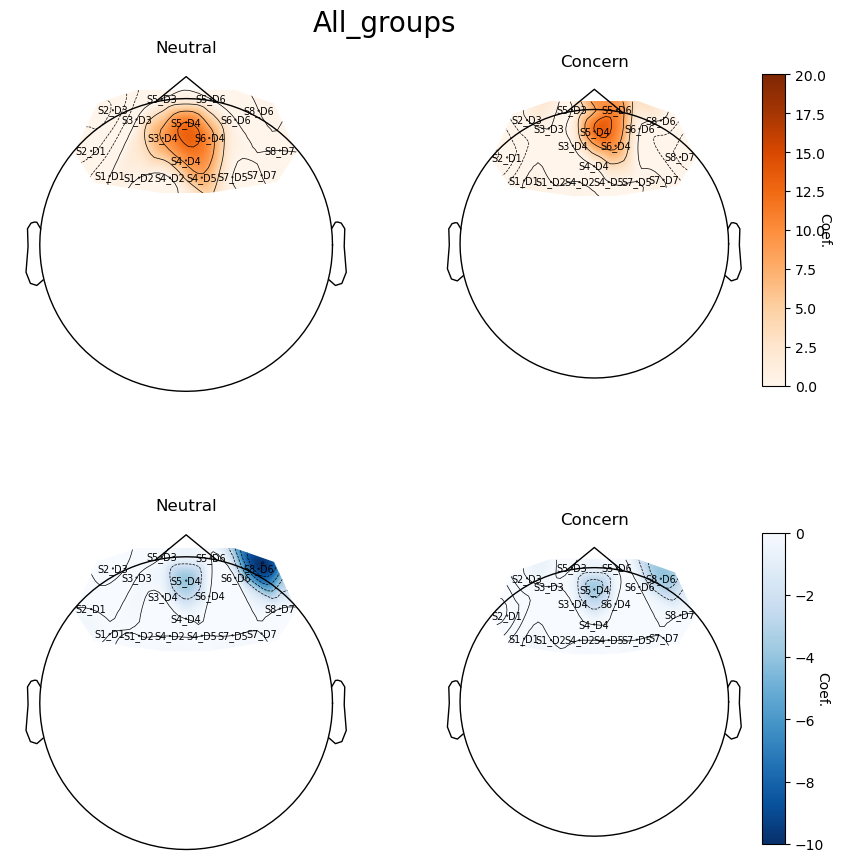

In [838]:
# Group Visualization
importlib.reload(visualizations)
groups = list(group_data.keys())
for group in groups:
    # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
    channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()
    raw_haemo = all_data[0]['raw_haemo']
    visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo, group)

In [906]:
# Compare the results between two conditions
importlib.reload(visualizations)
importlib.reload(analysis_tools)
importlib.reload(cross_conditional_comparison)
epochs = []
raw_data = []
# Collect all epochs
for key in all_epochs.keys():
    epochs = epochs + all_epochs[key]

# Collect all raw_data objects
for data in all_data:
    raw_data.append(data['raw_haemo'])

cross_conditional_comparison.two_sample_permutation_test(epochs, raw_data)



39


In [849]:
# Generate FDR Corrected Results
importlib.reload(visualizations)
importlib.reload(analysis_tools)
ignored_vals = ['drift', 'Start', 'constant']

groups = list(group_data.keys())
results = {}
for group in groups:
    # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
    channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()
    
    raw_haemo = all_data[0]['raw_haemo']

    alpha = 0.05
    p_vals = channels_df['p_value']
    reject_fdr, pval_fdr = fdr_correction(p_vals, alpha=alpha, method='indep')
    channels_df['fdr_status'] = reject_fdr
    channels_df_fdr = channels_df.loc[(channels_df['fdr_status'] == True) & (~channels_df['Condition'].isin(ignored_vals))]
    channels_df_fdr = channels_df_fdr.drop_duplicates()
    print(channels_df_fdr)
    channels_df_fdr.to_csv('FV_results_FDR.csv')
    
    # channels_df_fdr.to_csv('channels_df_fdr.csv')
    # visualizations.group_topological_visualisation(channels_df_fdr, columns_for_glm_contrast, raw_haemo, group)

variable Condition    df           mse   p_value            se         t  \
2499       Concern  21.0  3.952707e-12  0.000015  6.638443e-07  5.582270   
2500       Neutral  21.0  3.952707e-12  0.000032  6.638681e-07  5.269733   
2877       Concern  21.0  4.398019e-13  0.000015  2.214356e-07 -5.582270   
2878       Neutral  21.0  4.398019e-13  0.000032  2.214436e-07 -5.269733   
4788       Concern  21.0  2.722683e-11  0.000023  1.738461e-06  5.417276   
5166       Concern  21.0  2.175542e-12  0.000023  4.914171e-07 -5.417276   
9447       Neutral  22.0  2.802300e-12  0.000025  5.218644e-07 -5.303571   
9843       Neutral  22.0  4.937125e-13  0.000025  2.190470e-07  5.303571   
22207      Neutral  22.0  5.659533e-12  0.000005  7.972027e-07 -5.995148   
22603      Neutral  22.0  5.099430e-13  0.000005  2.392981e-07  5.995148   
24726      Concern  21.0  2.850885e-12  0.000012  5.767479e-07  5.673992   
25104      Concern  21.0  3.799713e-13  0.000012  2.105579e-07 -5.673992   

variable   

In [887]:
# Permutation T-test

all_data = group_data['all_groups']['all_data']
epochs = []

for d in all_data:
    # epochs.append(data['epoch'])
    raw = d['raw_haemo']
    picks = mne.pick_types(raw.info, fnirs=True, meg=False, eeg=False, stim=False, eog=True,
                       exclude='bads')

    data = d['epoch'].get_data()
    times = d['epoch'].times

    temporal_mask = np.logical_and(0.04 <= times, times <= 0.06)
    data = np.mean(data[:, :, temporal_mask], axis=2)

    n_permutations = 50000
    T0, p_values, H0 = permutation_t_test(data, n_permutations, n_jobs=None)
    print(T0, H0)
    significant_sensors = picks[p_values <= 0.05]
    significant_sensors_names = [raw.ch_names[k] for k in significant_sensors]

    print(significant_sensors_names)


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Permuting 49999 times...
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan] [nan nan nan ... nan nan nan]
['S1_D1 hbo', 'S1_D2 hbo', 'S2_D1 hbo', 'S2_D3 hbo', 'S3_D3 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D4 hbo', 'S4_D5 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S6_D6 hbo', 'S7_D5 hbo', 'S7_D7 hbo', 'S8_D6 hbo', 'S8_D7 hbo', 'S1_D1 hbr', 'S1_D2 hbr', 'S2_D1 hbr', 'S2_D3 hbr', 'S3_D3 hbr', 'S3_D4 hbr', 'S4_D2 hbr', 'S4_D4 hbr', 'S4_D5 hbr', 'S5_D3 hbr', 'S5_D4 hbr', 'S5_D6 hbr', 'S6_D4 hbr', 'S6_D6 hbr', 'S7_D5 hbr', 'S7_D7 hbr', 'S8_D6 hbr', 'S8_D7 hbr']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


KeyboardInterrupt: 

In [840]:
# # Group Cortical Projections
# importlib.reload(visualizations)
# groups = list(group_data.keys())
# for group in groups:
#     # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
#     channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()

#     raw_haemo = all_data[0]['raw_haemo']
#     visualizations.group_cortical_surface_projection(channels_df, columns_for_glm_contrast, raw_haemo, path)

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


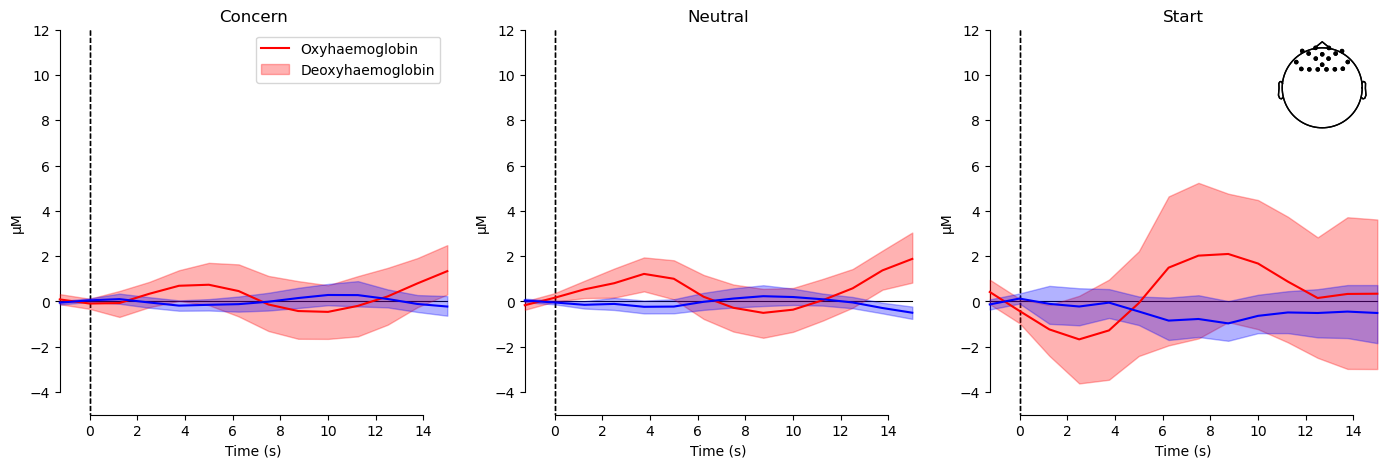

In [841]:
importlib.reload(visualizations)
visualizations.plot_waveform_analysis(all_evokeds, variable_epoch_time)

In [842]:
# Individual Visualization
# importlib.reload(visualizations)
# if individual_data:
#     channels_df, contrasts_df, significant_channels, all_data = individual_data['sub-1'].values()

#     raw_haemo = all_data[0]['raw_haemo']

#     visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo)

# Export Results

In [843]:
# Download the Results
keys = list(group_data.keys())
complete_results = pd.DataFrame()
for key in keys:
    sig_cha = group_data[key]['significant_channels']
    print(sig_cha)
    sig_cha['group'] = key
    complete_results = pd.concat([complete_results, sig_cha])
    complete_results['Coef.'] = complete_results['Coef.'] * 1e7
complete_results.to_csv('FV_results.csv')

                            Coef. Std.Err.         z         P>|z|    [0.025  \
ch_name   Condition                                                            
S2_D1 hbo Concern   -1.060151e-06      0.0 -2.963398  3.042631e-03 -0.000002   
          Neutral   -9.047090e-07      0.0 -2.528898  1.144213e-02 -0.000002   
S2_D3 hbo Neutral   -1.152084e-06      0.0 -3.220376  1.280226e-03 -0.000002   
S3_D4 hbo Neutral    8.481680e-07      0.0  2.370851  1.774718e-02       0.0   
S4_D4 hbo Neutral    8.889491e-07      0.0  2.484845  1.296079e-02       0.0   
S4_D5 hbo Neutral    7.473049e-07      0.0  2.088912  3.671560e-02       0.0   
S5_D4 hbo Concern    1.200302e-06      0.0  3.355159  7.931937e-04       0.0   
          Neutral    1.214254e-06      0.0  3.394157  6.884016e-04  0.000001   
S5_D6 hbo Concern    1.016629e-06      0.0  2.841744  4.486745e-03       0.0   
S6_D4 hbo Concern    8.835907e-07      0.0  2.469867  1.351633e-02       0.0   
          Neutral    9.736732e-07      0